<a href="https://colab.research.google.com/github/manisharavindh/basic-pytorch-models/blob/main/04_mnist_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [98]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [99]:
# data (MNIST dataset)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,),)
])

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,
    target_transform=None,
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
    target_transform=None,
    download=True
)

len(train_data), len(test_data)

(60000, 10000)

In [100]:
# class names
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

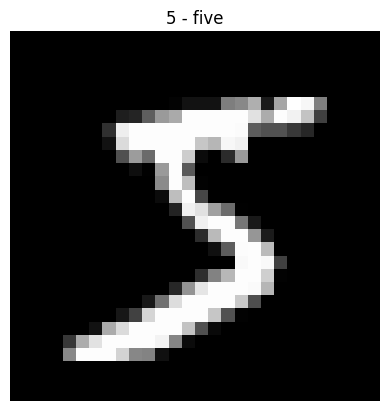

In [101]:
# data visualization
image, label = train_data[0]

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

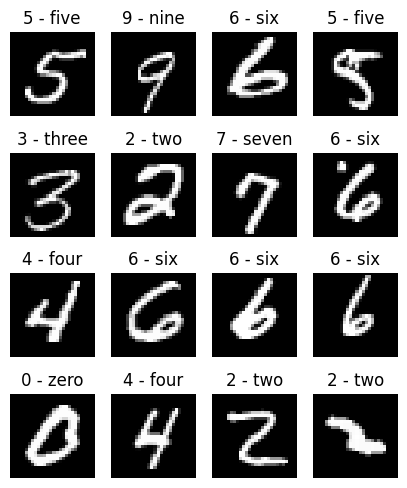

In [102]:
# visualizing random sampels
fig = plt.figure(figsize=(5, 6))
n = 4

for i in range(1, n*n+1):
  random_idx = torch.randint(1, len(train_data), size=[1]).item()
  img, lbl = train_data[random_idx]

  fig.add_subplot(n, n, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[lbl])
  plt.axis(False)

In [103]:
# data to dataloaders
BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [104]:
# model code
class MNISTModel(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 dropout_rate=0.25):
      super().__init__()
      self.features = nn.Sequential(
          nn.Conv2d(
              in_channels=input_shape,
              out_channels=32,
              kernel_size=3,
              padding=1
          ),
          nn.ReLU(inplace=True),
          nn.Conv2d(
              in_channels=32,
              out_channels=32,
              kernel_size=3,
              padding=1
          ),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(
              kernel_size=2,
              stride=2
          ),
          nn.Dropout(dropout_rate),

          nn.Conv2d(
              in_channels=32,
              out_channels=64,
              kernel_size=3,
              padding=1
          ),
          nn.ReLU(inplace=True),
          nn.Conv2d(
              in_channels=64,
              out_channels=64,
              kernel_size=3,
              padding=1
          ),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(
              kernel_size=2,
              stride=2
          ),
          nn.Dropout(dropout_rate)
      )

      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(
              in_features=64*7*7,
              out_features=256
          ),
          nn.ReLU(inplace=True),
          nn.Dropout(dropout_rate),
          nn.Linear(
              in_features=256,
              out_features=output_shape
          )
      )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
      x = self.features(x)
      return self.classifier(x)

In [105]:
model = MNISTModel(
    input_shape=1,
    output_shape=len(class_names),
    dropout_rate=0.25
).to(device)

model

MNISTModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [106]:
image.shape

torch.Size([1, 28, 28])

In [107]:
# dummy testing
x_dummy = torch.rand(1, 1, 28, 28)
model(x_dummy.to(device))

tensor([[-0.0020,  0.0619,  0.0118,  0.0044, -0.0190, -0.0574,  0.0204, -0.0349,
         -0.0224,  0.0451]], grad_fn=<AddmmBackward0>)

In [108]:
# train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               accuracy_fn,
               device: torch.device=device):
  train_loss, train_acc = 0, 0

  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y, y_pred.argmax(dim=1))
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

In [109]:
# test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X_test, y_test in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

In [110]:
# timing function
from timeit import default_timer as timer

def print_total_time(start: float,
                     end: float,
                     device: torch.device=device):
  total_time = end-start
  return f"Total Time on {device}: {total_time:.2f} seconds"

In [111]:
# loss_fn, optimizer, and accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct/len(y_pred)) * 100

In [112]:
# training loop
from tqdm.auto import tqdm

epochs = 3
start = timer()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")

  train_step(
      model=model,
      dataloader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device
  )

  test_step(
      model=model,
      dataloader=test_dataloader,
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn,
      device=device
  )

end = timer()

print_total_time(
    start=start,
    end=end,
    device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train Loss: 0.1368 | Train Acc: 95.75%
Test Loss: 0.0327 | Test Acc: 98.98%
Epoch: 1
-----
Train Loss: 0.0520 | Train Acc: 98.40%
Test Loss: 0.0327 | Test Acc: 98.91%
Epoch: 2
-----
Train Loss: 0.0402 | Train Acc: 98.80%
Test Loss: 0.0271 | Test Acc: 99.22%


'Total Time on cpu: 717.70 seconds'

In [121]:
class_names[model(test_data[0][0].unsqueeze(dim=1)).argmax(dim=1)]

'7 - seven'

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

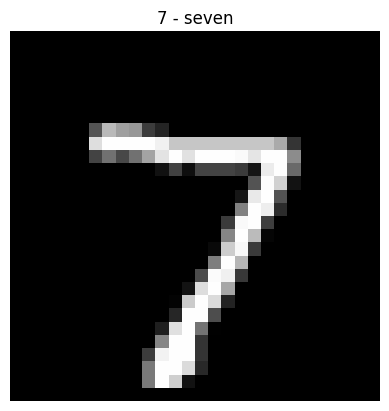

In [122]:
plt.imshow(test_data[0][0].squeeze(), cmap='gray')
plt.title(class_names[test_data[0][1]])
plt.axis(False)

In [137]:
# random preds
import random

def plot_random_preds(model: torch.nn.Module,
                      data: torchvision.datasets,
                      class_names: list,
                      n: int=16,
                      device: torch.device=device):
  random_images = []
  random_labels = []
  random_preds = []

  for X, y in random.sample(list(data), k=n):
    random_images.append(X)
    random_labels.append(y)

  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in random_images:
      sample = sample.unsqueeze(0).to(device)

      preds = torch.softmax(model(sample).squeeze(), dim=0).argmax(dim=0)
      random_preds.append(preds.to('cpu'))

  plt.figure(figsize=(12, 7))
  row, col = 4, 4

  for i, X in enumerate(random_images):
    plt.subplot(row, col, i+1)

    plt.imshow(X.squeeze(), cmap='gray')

    pred_label = class_names[random_preds[i]]
    truth_label = class_names[random_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
      plt.title(title_text, c='g', fontsize=10)
    else:
      plt.title(title_text, c='r', fontsize=10)

    plt.axis('off')

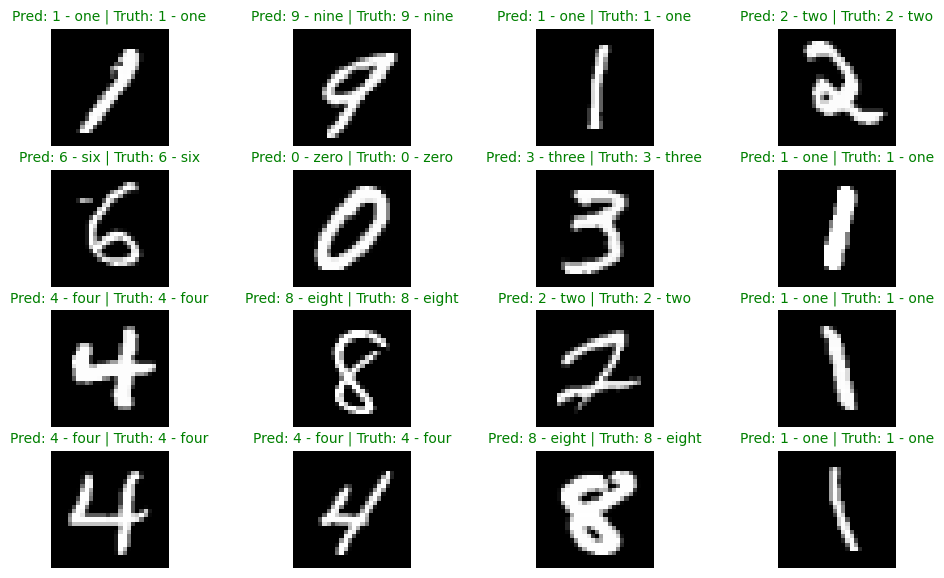

In [138]:
plot_random_preds(
    model=model,
    data=test_data,
    class_names=class_names,
    n=16,
    device=device
)